In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

print(f"Merged shape: {train.shape}")
train.head()


Merged shape: (590540, 434)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [3]:
columns_to_exclude = ['id_33', 'id_31', 'id_30', 'P_emaildomain', 'R_emaildomain', 'DeviceInfo']
categorical_features = [col for col in train.columns if train[col].dtype == 'object' and col not in columns_to_exclude]
numerical_features = [col for col in train.columns if train[col].dtype != 'object' and col not in ['TransactionID', 'TransactionDT', 'isFraud']]


In [4]:
pip show scikit-learn imbalanced-learn


Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bayesian-optimization, bigframes, Boruta, category_encoders, cesium, eli5, fastai, hep_ml, imbalanced-learn, librosa, lime, mlflow, mlxtend, nilearn, pyLDAvis, rgf-python, scikit-learn-intelex, scikit-optimize, scikit-plot, sentence-transformers, shap, sklearn-compat, sklearn-pandas, TPOT, tsfresh, woodwork, yellowbrick
---
Name: imbalanced-learn
Version: 0.11.0
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 
Note: you may need to restart the kernel to use updated 

In [5]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0
import sklearn

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X = train.drop(columns='isFraud')
y = train['isFraud']

rus = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Cleaning

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, numerical_columns):
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns

    def fit(self, X, y=None):
        # No fitting required as we use fixed fill values
        return self

    def transform(self, X):
        data = X.copy()
        
        # Remove unreliable or irrelevant features
        columns_to_remove = ['id_33', 'id_31', 'id_30', 'P_emaildomain', 'R_emaildomain', 'DeviceInfo', 'TransactionID', 'TransactionDT']
        data.drop(columns=columns_to_remove, inplace=True, errors='ignore')

        # Handle missing values for categorical variables
        for col in self.categorical_columns:
            data[col] = data[col].fillna(f'missing_{col}')
        
        # Handle missing values for numerical variables
        for col in self.numerical_columns:
            data[col] = data[col].fillna(0)

        return data


In [8]:
filler = MissingValueImputer(categorical_features, numerical_features)

In [9]:
X_train = filler.fit_transform(X_train)

In [10]:
nanValues = [i for i in train.columns if train[i].isna().sum()/len(train) > 0.9]
oneValue= [i for i in train.columns if train[i].nunique()<=1]
constValue = [i for i in train.columns if train[i].value_counts(dropna=False, normalize=True).values[0] > 0.9]


In [11]:
nanValues

['dist2',
 'D7',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

In [12]:
oneValue

[]

In [13]:
constValue

['isFraud',
 'dist2',
 'C3',
 'D7',
 'V98',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V129',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V281',
 'V284',
 'V286',
 'V290',
 'V293',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V305',
 'V309',
 'V311',
 'V316',
 'V318',
 'V319',
 'V320',
 'V321',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

# Feature Engineering

In [14]:
imputer = MissingValueImputer(categorical_columns=categorical_features, numerical_columns=numerical_features)
filled_data = imputer.transform(X_resampled)

woe_mappings = {}

total_fraud = (y_resampled == 1).sum()
total_nonfraud = (y_resampled == 0).sum()

for col in categorical_features:
    col_woe = {}
    unique_entries = filled_data[col].unique()

    for entry in unique_entries:
        fraud_count = ((X_resampled[col] == entry) & (y_resampled == 1)).sum() + 1
        nonfraud_count = ((X_resampled[col] == entry) & (y_resampled == 0)).sum() + 1

        woe_value = np.log((fraud_count / total_fraud) / (nonfraud_count / total_nonfraud))
        col_woe[entry] = woe_value

    woe_mappings[col] = col_woe


In [15]:
!pip install dagshub mlflow
import dagshub
import mlflow
dagshub.init(repo_owner='TamariToradze', repo_name='IEEE-CIS-Fraud-Detection_ass2', mlflow=True)

Accessing as TamariToradze

Initialized MLflow to track repo "TamariToradze/IEEE-CIS-Fraud-Detection_ass2"

Repository TamariToradze/IEEE-CIS-Fraud-Detection_ass2 initialized!

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
import mlflow

class WoETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mappings):
        self.mappings = mappings

    def fit(self, X, y=None):
        mlflow.log_dict(self.mappings, artifact_file="woe_values.json")
        return self

    def transform(self, X):
        transformed = X.copy()
        
        for feature, value_map in self.mappings.items():
            transformed[feature] = transformed[feature].map(value_map)
        
        return transformed


In [17]:
en = WoETransformer(woe_mappings)

In [18]:
X_train = en.fit_transform(X_train)

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
import mlflow

class DominantLowVarianceRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold_missing=0.9, threshold_constant=0.9):
        self.threshold_missing = threshold_missing
        self.threshold_constant = threshold_constant
        self.columns_to_remove = []

    def fit(self, X, y=None):
        self.columns_to_remove = []

        for col in X.columns:
            missing_ratio = X[col].isna().mean()
            unique_count = X[col].nunique(dropna=False)
            most_freq_ratio = X[col].value_counts(dropna=False, normalize=True).values[0] if not X[col].empty else 0

            if (
                missing_ratio > self.threshold_missing or
                unique_count <= 1 or
                most_freq_ratio > self.threshold_constant
            ):
                self.columns_to_remove.append(col)

        mlflow.log_dict({"removed_columns": self.columns_to_remove}, artifact_file="dominant_low_variance_removed.json")
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_remove, errors='ignore')


In [20]:
remover = DominantLowVarianceRemover()
remover.fit(X_train)                
X_train = remover.transform(X_train) 


# Feature Selection

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# C correlation map

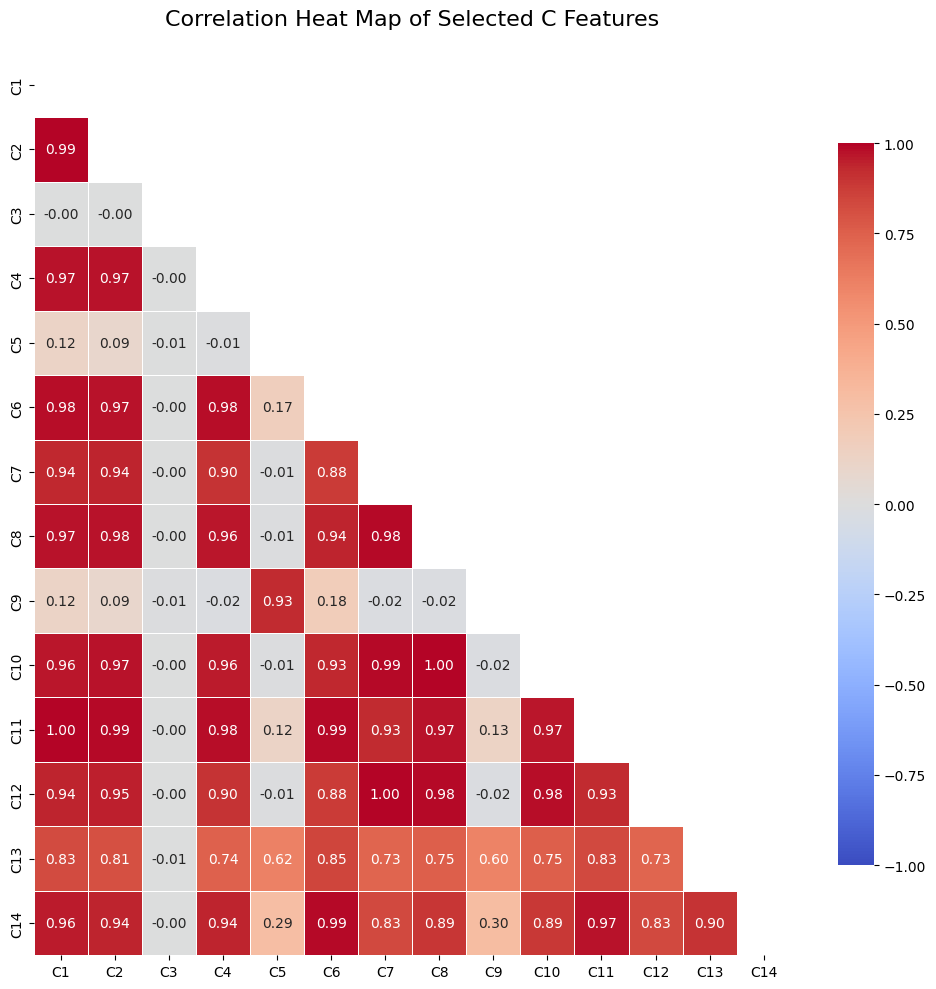

In [22]:
cor_cols = [f"C{i}" for i in range(1, 15) if f"C{i}" in X_resampled.columns]
corr_matrix = X_resampled[cor_cols].corr()
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Heat Map of Selected C Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


In [23]:
colsC = ['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# id coorelation map

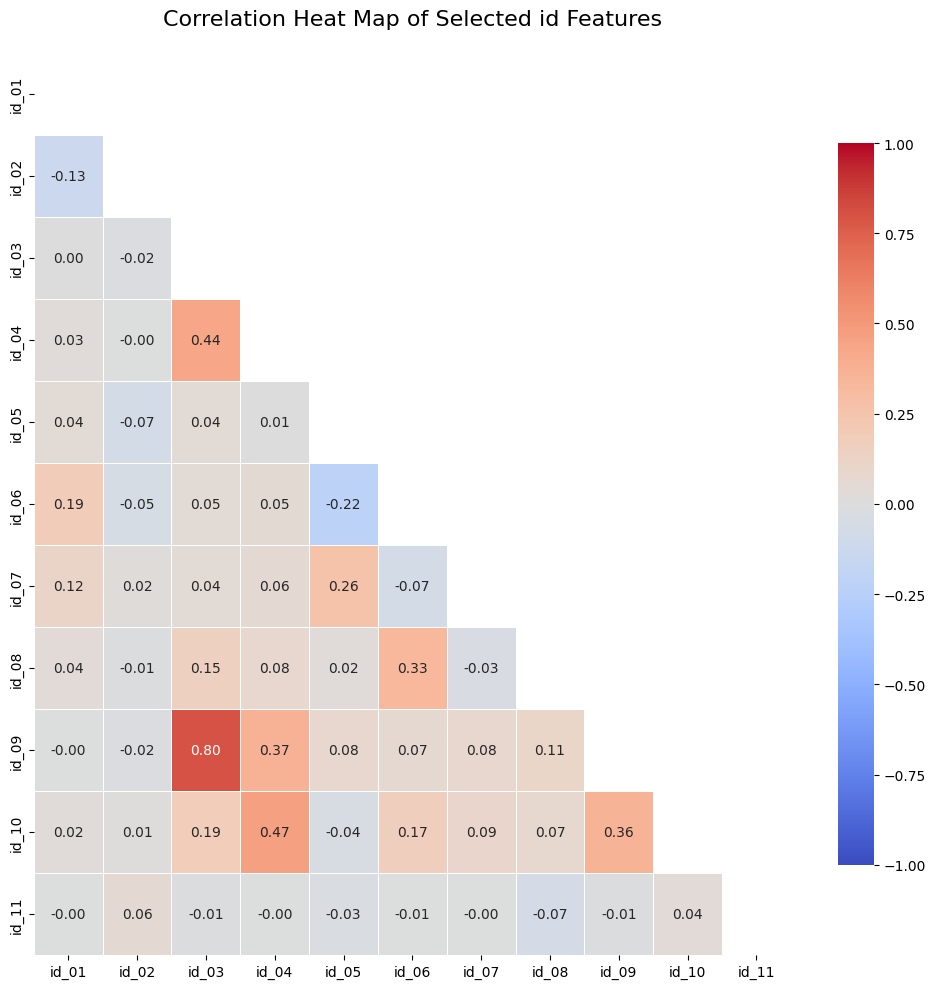

In [24]:
cor_cols = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11']
cor_cols= [f for f in cor_cols if f in X_resampled.columns]
corr_matrix = X_resampled[cor_cols].corr()
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Heat Map of Selected id Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


No id_num_deature feature seem to have be highly inter correlated.

# D coorelation map

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


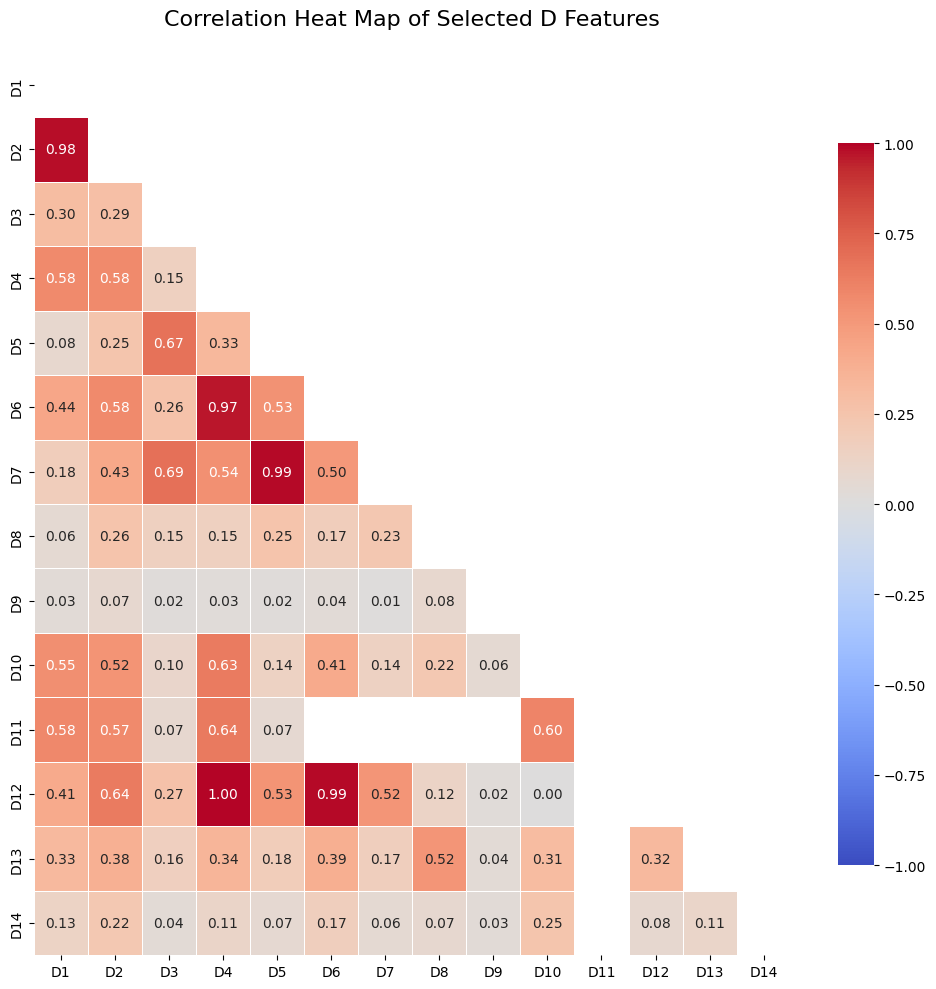

In [25]:
cor_cols = [f"D{i}" for i in range(1, 15) if f"D{i}" in X_resampled.columns]
corr_matrix = X_resampled[cor_cols].corr()
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Heat Map of Selected D Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


Only three D_features seem to be correlated.

# V coorelation map

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


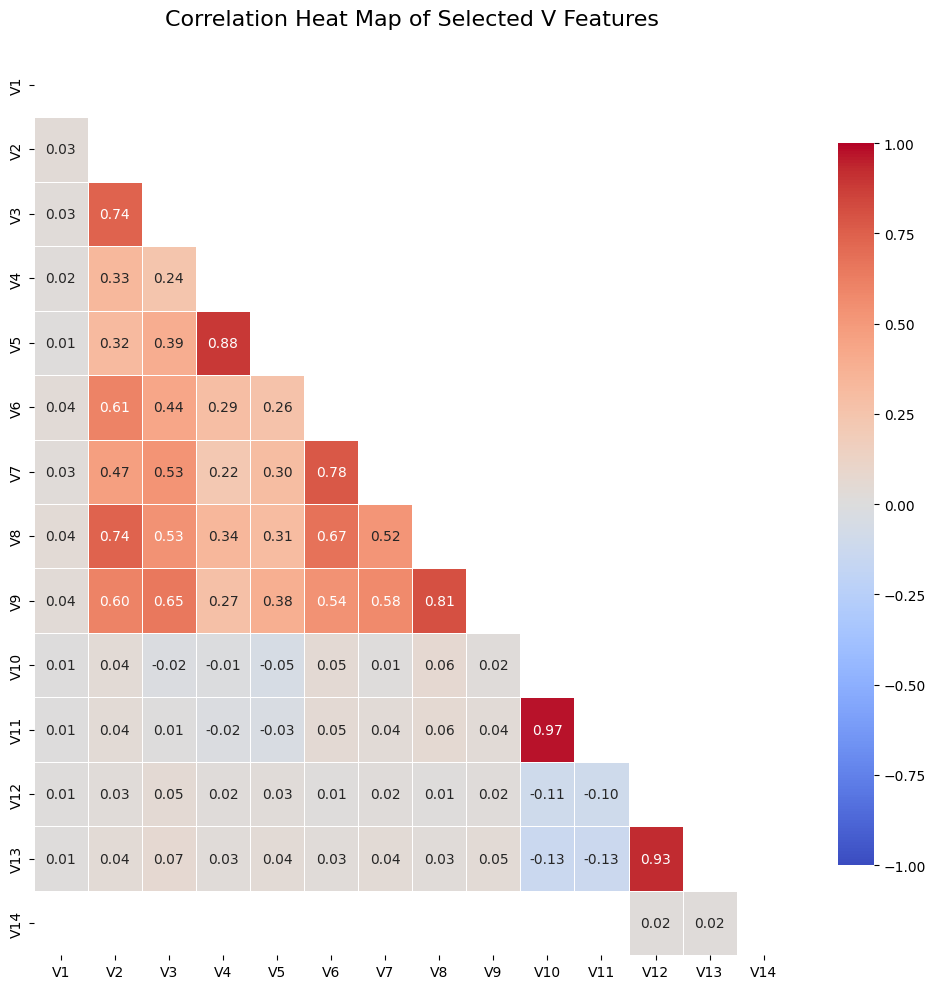

In [26]:
cor_cols = [f"V{i}" for i in range(1, 15) if f"V{i}" in X_resampled.columns]
corr_matrix = X_resampled[cor_cols].corr()
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Heat Map of Selected V Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


In [27]:
correlation_threshold = 0.8

In [28]:
absolute_corr = X_train.corr().abs()

upper_triangle_mask = np.triu(np.ones(absolute_corr.shape), k=1).astype(bool)
strongly_correlated = [
    (absolute_corr.columns[row], absolute_corr.columns[col], absolute_corr.values[row, col])
    for row in range(absolute_corr.shape[0])
    for col in range(absolute_corr.shape[1])
    if upper_triangle_mask[row, col] and absolute_corr.values[row, col] > correlation_threshold
]

In [29]:
drop_candidates = []
for f1, f2, _ in strongly_correlated:
    if abs(X_train[f1].corr(y_train)) < abs(X_train[f2].corr(y_train)):
        drop_candidates.append(f1)
    else:
        drop_candidates.append(f2)

drop_candidates = list(set(drop_candidates))


In [30]:
drop_candidates

['V262',
 'V64',
 'V171',
 'V31',
 'V63',
 'M4',
 'V256',
 'V154',
 'V58',
 'id_16',
 'id_20',
 'V313',
 'V86',
 'V49',
 'C10',
 'C11',
 'id_14',
 'V199',
 'M8',
 'V95',
 'V73',
 'V9',
 'V90',
 'V245',
 'V59',
 'C4',
 'V204',
 'V304',
 'V288',
 'C13',
 'V203',
 'V195',
 'V131',
 'V249',
 'V16',
 'V84',
 'V201',
 'V41',
 'V57',
 'V44',
 'V17',
 'C8',
 'V69',
 'V60',
 'V153',
 'V176',
 'V192',
 'V187',
 'V133',
 'V279',
 'V32',
 'M7',
 'C1',
 'V219',
 'C12',
 'V6',
 'V25',
 'id_35',
 'V103',
 'addr2',
 'V70',
 'id_19',
 'V314',
 'V202',
 'id_36',
 'V79',
 'V15',
 'V52',
 'V18',
 'V230',
 'V193',
 'V308',
 'V228',
 'V295',
 'V200',
 'V248',
 'V26',
 'V149',
 'V2',
 'V250',
 'V8',
 'V317',
 'V134',
 'V3',
 'V46',
 'V246',
 'V303',
 'V127',
 'V96',
 'V318',
 'V22',
 'V94',
 'V229',
 'V43',
 'V157',
 'V42',
 'id_15',
 'V81',
 'V140',
 'V218',
 'V243',
 'V240',
 'V30',
 'V67',
 'V7',
 'V254',
 'V21',
 'V252',
 'id_29',
 'V48',
 'V77',
 'V80',
 'V82',
 'V128',
 'V100',
 'V191',
 'V4',
 'V76',


In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
import mlflow

class HighlyCorrelatedFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_remove):
        self.columns_to_remove = columns_to_remove
        self.threshold = 0.8 

    def fit(self, X, y=None):
        mlflow.log_dict({"dropped_features": self.columns_to_remove}, artifact_file="dropped_features.json")
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_remove, errors='ignore')


In [32]:
filt = HighlyCorrelatedFeatureRemover(drop_candidates)

In [33]:
X_train = filt.fit_transform(X_train)

In [34]:
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE

xgb_model = XGBRegressor(
    n_estimators=250,      
    max_depth=7,           
    learning_rate=0.08,    
    subsample=0.85,        
    colsample_bytree=0.75,
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

feature_selector = RFE(estimator=xgb_model, n_features_to_select=100)
feature_selector.fit(X_train, y_train)

important_features = X_train.columns[feature_selector.support_].tolist()


In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
import mlflow

class RFEFeatureSubset(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_keep):
        self.features_to_keep = features_to_keep

    def fit(self, X, y=None):
        mlflow.log_dict({"retained_features": self.features_to_keep}, artifact_file="retained_features.json")
        return self

    def transform(self, X):
        return X[self.features_to_keep].copy()


In [36]:
rfe = RFEFeatureSubset(important_features)

In [37]:
X_train = rfe.fit_transform(X_train)

In [38]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.75, 0.85]
}

xgb = XGBRegressor(
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',  # Or use another metric as needed
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

rfe = RFE(estimator=best_model, n_features_to_select=100)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_].tolist()


Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [39]:
rfebest = RFEFeatureSubset(selected_features)

In [40]:
X_train = rfebest.fit_transform(X_train)

In [41]:
print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)


Best hyperparameters found by GridSearchCV:
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.9}


# Training

In [42]:
import shap
import tempfile
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import pandas as pd
import mlflow.sklearn
import os
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

mlflow.set_experiment("XGB_2")
threshold = 0.3  # Decision threshold for positive classification

# Build full ML pipeline with best parameters from GridSearchCV
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=0.3, random_state=42)),
    ('missing_handler', MissingValueImputer(categorical_columns=categorical_features, numerical_columns=numerical_features)),
    ('woe_encode', WoETransformer(mappings=woe_mappings)),
    ('drop_low_info', DominantLowVarianceRemover()),
    ('remove_corr', HighlyCorrelatedFeatureRemover(columns_to_remove=drop_candidates)),
    ('feature_selector', RFEFeatureSubset(features_to_keep=selected_features)),
    ('model', XGBClassifier(
        n_estimators=150,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.75,
        reg_alpha=5,
        reg_lambda=5,
        gamma=3,
        use_label_encoder=False,
        eval_metric='aucpr',
        random_state=42,
        n_jobs=-1
    ))
])

# Start logging with MLflow
with mlflow.start_run(run_name="XGB_2", nested=True) as run:
    pipeline.fit(X_train, y_train)

    mlflow.sklearn.log_model(pipeline, "model")

    model_params = pipeline.named_steps['model'].get_params()
    params_to_log = {
        "sampling_strategy": 0.3,
        "n_estimators": model_params['n_estimators'],
        "max_depth": model_params['max_depth'],
        "learning_rate": model_params['learning_rate'],
        "subsample": model_params['subsample'],
        "colsample_bytree": model_params['colsample_bytree'],
        "reg_alpha": model_params['reg_alpha'],
        "reg_lambda": model_params['reg_lambda'],
        "gamma": model_params['gamma'],
        "random_state": model_params['random_state']
    }
    mlflow.log_params(params_to_log)

    def log_evaluation(X, y, label, threshold):
        scores = pipeline.predict_proba(X)[:, 1]
        predictions = (scores >= threshold).astype(int)

        metrics = {
            f"{label}_precision": precision_score(y, predictions),
            f"{label}_recall": recall_score(y, predictions),
            f"{label}_f1": f1_score(y, predictions),
            f"{label}_roc_auc": roc_auc_score(y, scores),
            f"{label}_threshold": threshold
        }
        mlflow.log_metrics(metrics)

        # Precision-Recall curve
        prec, rec, _ = precision_recall_curve(y, scores)
        plt.figure()
        plt.plot(rec, prec)
        plt.axvline(x=metrics[f"{label}_recall"], linestyle='--', color='red')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{label.capitalize()} Precision-Recall")
        pr_filename = f"{label}_pr_curve.png"
        plt.savefig(pr_filename)
        plt.close()
        mlflow.log_artifact(pr_filename)

        # ROC curve
        fpr, tpr, _ = roc_curve(y, scores)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {metrics[f'{label}_roc_auc']:.3f}")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{label.capitalize()} ROC Curve")
        plt.legend()
        roc_filename = f"{label}_roc_curve.png"
        plt.savefig(roc_filename)
        plt.close()
        mlflow.log_artifact(roc_filename)

        # Confusion matrix
        cm = confusion_matrix(y, predictions)
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, cmap=plt.cm.Blues)
        plt.title(f"{label.capitalize()} Confusion Matrix")
        plt.colorbar()
        tick_labels = ["Non-Fraud", "Fraud"]
        plt.xticks(range(2), tick_labels)
        plt.yticks(range(2), tick_labels)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")

        thresh = cm.max() / 2
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i, j], ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black", fontsize=16)

        cm_filename = f"{label}_confusion_matrix.png"
        plt.savefig(cm_filename)
        plt.close()
        mlflow.log_artifact(cm_filename)

    # Evaluate on training and test sets
    log_evaluation(X_train, y_train, label="train", threshold=threshold)
    log_evaluation(X_test, y_test, label="test", threshold=threshold)

    print(f"MLflow tracking complete. Run ID: {run.info.run_id}")


2025/04/30 15:21:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow tracking complete. Run ID: 2fc389060bb1454ba323eb5f31b3e4c7
🏃 View run XGB_2 at: https://dagshub.com/TamariToradze/IEEE-CIS-Fraud-Detection_ass2.mlflow/#/experiments/2/runs/2fc389060bb1454ba323eb5f31b3e4c7
🧪 View experiment at: https://dagshub.com/TamariToradze/IEEE-CIS-Fraud-Detection_ass2.mlflow/#/experiments/2
